In [1]:
import tifffile as tif
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import numpy as np
import skimage
from skimage import filters, color, morphology, exposure
import cv2 as cv
import os

In [2]:
def show_figures_subplots(images, im_titles, rows, cols, size=10):
  # util function to show multiple images
  fig, axes = plt.subplots(rows, cols, figsize=(size,size))
  if not rows==cols==1:
    # Flatten the axes array 2d->1d
    axes = axes.flatten()
    # Display each image
    for idx, img in enumerate(images):
        ax = axes[idx]
        ax.imshow(img, cmap=plt.cm.gray)
        if im_titles is not None:
          ax.set_title(f'{im_titles[idx]}')
        ax.axis('on')
    # for ax in axes[len(tiff_files):]:
    #     fig.delaxes(ax) # close unused axes
    plt.tight_layout()
    plt.show()
  else:
    axes.imshow(images[0], cmap=plt.cm.gray)
    # axes[0].set_title(f'Image {im_titles[0]}')
    plt.show()

Get file paths  

All images are in tif format

In [6]:
file_paths = []
for root, dirs, files in os.walk("./input_folder_name"): # define input folder name
    for file in files:
        if ".tif" in file:
          # if "2a" in file or "2c" in file:
            # Get the absolute path of the file
            file_path = os.path.join(root, file)
            file_paths.append(os.path.abspath(file_path))

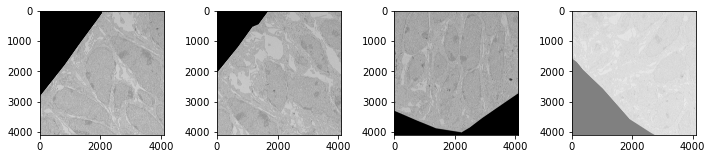

In [8]:
tiff_imgs = [tif.imread(f) for f in file_paths[:4]]
img_titles = [f"sample {i}" for i in range(len(tiff_imgs))]
show_figures_subplots(tiff_imgs, None, 1, 4, 10)

Segmentation

In [9]:
from scipy.signal import find_peaks
from skimage.filters import threshold_otsu, rank, gaussian
from skimage.morphology import area_closing, disk
from skimage import exposure
from skimage.util import view_as_windows

max_area = 1000000
min_area = 1000

In [10]:
def sliding_binarize(im, window_size=512, stride=65):
  stride = stride
  window_size = (window_size, window_size)
  windows = view_as_windows(im, window_size, step=stride)
  im_uint8 = cv.convertScaleAbs(im, alpha=(255.0/65535.0))
  equalized_im = cv.equalizeHist(im_uint8)
  global_p = 80
  global_t =  np.percentile(im, global_p)
  global_t_uint8 =  np.percentile(im_uint8, global_p)
  print(global_t, global_t_uint8)
  output_image = np.zeros_like(im, dtype=bool)
  # Iterate over the windows
  for i in tqdm(range(windows.shape[0]), position=0, leave=True):
      for j in range(windows.shape[1]):
          window = windows[i, j]  # Get the current window
          window_uint16 = window
          # show_figures_subplots([window], ['sample'], 1, 1, 10)

          if np.all(window == 2**15):
            binary = np.zeros_like(window)
          else:
            mask = window != 2**15
            masked_window = window[mask] #only for computing metrics
            
            masked_window_uint16 = masked_window
            masked_window = cv.convertScaleAbs(masked_window, alpha=(255.0/65535.0))
            window = cv.convertScaleAbs(window, alpha=(255.0/65535.0))
            hist, bin_edges = np.histogram(masked_window, bins=255)
            bin_edges = bin_edges[:-1]
            idx = np.where(hist == 0)[0]
            hist = hist[hist!=0]
            bin_centers = np.delete(bin_edges, idx)
            peaks, peaks_values = find_peaks(hist, height=5000)

            # Binarize the window
            if len(peaks) > 1:
              otsu = threshold_otsu(masked_window)
              otsu += 3 # under-segment to avoid too big small segments
              if global_t_uint8 - otsu > 3:
                otsu = global_t-1
              binary_otsu = np.zeros_like(window, dtype=bool)
              binary_otsu[mask] = window[mask] > otsu
              binary = binary_otsu
              thr = f"otsu {otsu}"
            else:
              local_p = 80
              local_t = np.percentile(masked_window_uint16, local_p)
              if local_t - global_t >400: # local intensity too high
                local_t-=300
              binary_local = np.zeros_like(window, dtype=bool)
              binary_local = window_uint16 > local_t
              binary = binary_local
              thr = f"local_t {local_t}"
#           if i == 48 and j > 30:
#             print(thr)
#             show_figures_subplots([equalized_im, window, binary], None, 1, 3, 15)
#           if i == 49:
#             break
#           take the union of overlapping slidings
#           take union to keep the window small while taking surrongding evn into account
          binary = binary.astype(bool)
          start_x, start_y = i * stride, j * stride
          end_x, end_y = start_x + window_size[0], start_y + window_size[1]
          output_image[start_x:end_x, start_y:end_y] |= binary  # Union of 1s
#       else:
#         continue
#       break
  # Convert bool to uint8 for visualization
  output_image = output_image.astype(np.uint8) * 255
  
  return equalized_im, output_image
  

In [ ]:

image_outputs = []
for idx, file_name in enumerate(file_paths):
    print(f"current image/all images: {idx}/{len(file_paths)}")
    print(f"processing {file_name}")
    im = tif.imread(file_name)
    equalized_im, output_image = sliding_binarize(im, window_size=1024, stride = 64)
    image_outputs.append(output_image)

In [12]:
image_opening = []
for output_image in tqdm(image_outputs):
    kernel_size = 2 
    kernel = np.ones((kernel_size, kernel_size),np.uint8)
    closing = cv.morphologyEx(output_image, cv.MORPH_CLOSE, kernel)
    area_closed = area_closing(closing)
    kernel_size = 8  
    kernel = np.ones((kernel_size, kernel_size),np.uint8)
    opening = cv.morphologyEx(area_closed, cv.MORPH_OPEN, kernel)
    image_opening.append(opening)
   

100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [18:07<00:00, 15.53s/it]


### save segmentation labels

In [13]:
image_labels = []
for opening in image_opening:
    contours, _ = cv.findContours(opening, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    label_image = np.zeros_like(opening)
    for label, contour in enumerate(contours, start=1):
        # Check if the contour area is larger than the threshold
        if cv.contourArea(contour) > 2500:
            # Contour is larger, label it with 1
            cv.drawContours(label_image, [contour], -1, (2,), thickness=cv.FILLED)
        else:
            cv.drawContours(label_image, [contour], -1, (1,), thickness=cv.FILLED)
    image_labels.append(label_image)

In [14]:
for idx, i in enumerate(file_paths):
    fn = os.path.split(i)[-1]
    if not  os.path.isdir("./labels_168_new"):
        os.mkdir("./labels_168_new")
    np.save(os.path.join("./labels_168_new/", fn.split(".")[0]+".npy"), image_labels[idx])
 
    

check results

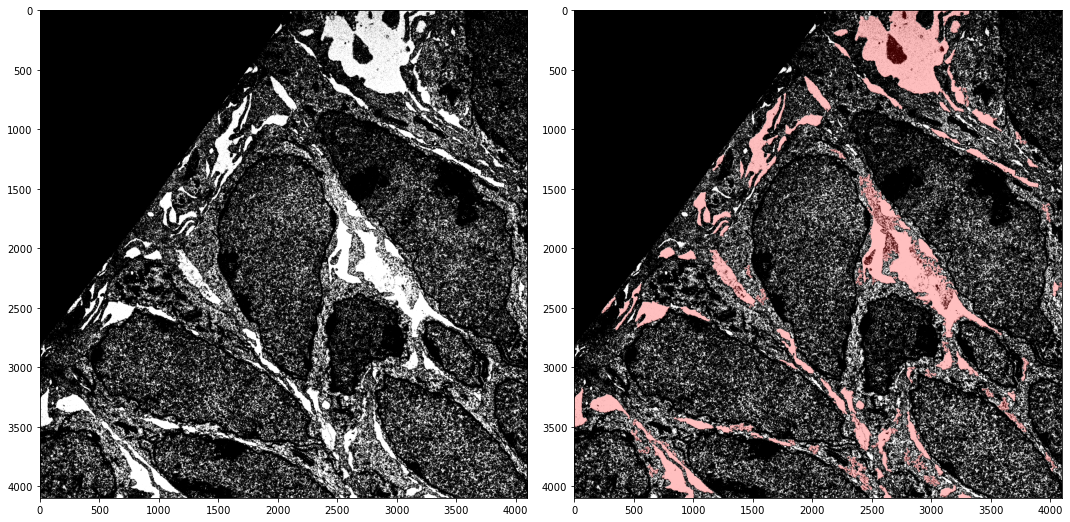

In [15]:
for opening, output_image in zip(image_opening, image_outputs):
    contours, _ = cv.findContours(opening, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    large_contours = [cnt for cnt in contours if cv.contourArea(cnt) > 2500]
    color_image = cv.cvtColor(output_image, cv.COLOR_GRAY2RGB)
    bg_image = color_image.copy()
    draw_contour_image = color_image.copy()
    color = (255,0,0) #red
    cv.drawContours(draw_contour_image, large_contours, -1, color, thickness=cv.FILLED)
    # blend with original image
    alpha = 0.25 # control the transparency of the contours
    result = cv.addWeighted(bg_image, 1-alpha, draw_contour_image, alpha, 0)
    show_figures_subplots([ output_image,  result], None,1, 2, 15)
    break